# Sales Forecasting Project

In [1]:
# Necessary Imports
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

##### Get the present working directory

In [4]:
pwd = os.getcwd()
filepath = os.path.join(pwd, "sales.csv")
filepath

'/Users/amishatiwari/Documents/ml/sales_forecasting_project/sales.csv'

##### Load the data set

In [5]:
sales_data = pd.read_csv(filepath)
sales_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


## Exploratory Data Analysis

##### Fetching the dataframe's structure, including column names, data types, non-null counts, and memory usage.

In [6]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


##### Check for null values in each feature in the df

In [7]:
# This checks for null values in each feature and get it's sum
sales_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##### Check for duplicate values in each feature in the df

In [8]:
sales_data.duplicated().sum()

0

##### Generating a statistical summary of the numerical columns in the df

In [9]:
sales_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800



##### Getting all the categorical variable (features with 'object' datatype) in a list

In [10]:
categorical_columns = []

# iterating over the columns in the df
for feature in sales_data.columns:
    if sales_data[feature].dtype == "object":
        categorical_columns.append(feature)

categorical_columns

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

##### Removing 'Item_Identifier' and 'Outlet_Identifier' from the list since they don't require cleaning. They are identifiers for items and outlets.

In [11]:
categorical_columns.remove('Item_Identifier')
categorical_columns.remove('Outlet_Identifier')

categorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

##### Getting a count of unique values of each categorical column

In [12]:
for column in categorical_columns:
    print(column, len(sales_data[column].unique()))

Item_Fat_Content 5
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


##### For each categorical column, printing the value counts

In [13]:
for column in categorical_columns:
    print(column)
    print(sales_data[column].value_counts(), '\n')
    print('-' * 55)

Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64 

-------------------------------------------------------
Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64 

-------------------------------------------------------
Outlet_Size
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64 

-------------------------------------------------------
Outlet_Location_Type
Outlet_Location_Type
Tier 3    3350
Tier 2  

## Data Cleaning

### Dealing with missing values

#### Dealing with missing Item_Weight values

##### Fetching all the data from the df where 'Item_Weight' is null

In [14]:
item_weight_null_rows = sales_data[sales_data["Item_Weight"].isnull()]
item_weight_null_rows

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


##### Identifying unique value counts in Item_Identifier column from the item_weight null values dataset

In [15]:
item_weight_null_rows["Item_Identifier"].value_counts()

Item_Identifier
FDK08    2
FDA08    2
FDV23    2
FDY56    2
FDI04    2
        ..
FDM44    1
FDZ48    1
FDK41    1
FDD57    1
NCN18    1
Name: count, Length: 1142, dtype: int64

##### Creates a new df where each row represents a unique Item_Identifier, and the corresponding value is the mean weight of all items with that identifier.

In [16]:
Item_Weight_Mean = sales_data.pivot_table(values='Item_Weight', index='Item_Identifier', aggfunc='mean')
Item_Weight_Mean

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


##### Treating the missing values of Item_Weight column with the mean values we got using the pivot table (new df) and filling it with respect to Item_Identifier column

In [17]:
# converting the Item_Weight_Mean to a dictionary for better mapping
item_weight_map = Item_Weight_Mean['Item_Weight'].to_dict()

In [18]:
# Finding the mean weight of all the Item weights in sales_data df
overall_mean_weight = sales_data["Item_Weight"].mean()

In [19]:
# Using the pivot table to fill the Item_Weight missing values. There are some cases where Item_Identifier does not exist in the pivot table. 
# In such cases, we fill the Item_Weight value as the overall mean value of Item_Weights.
sales_data["Item_Weight"] = sales_data["Item_Weight"].fillna(sales_data["Item_Identifier"].map(item_weight_map)).fillna(overall_mean_weight)

##### Checking if the Item_Weight values are still null or not

In [20]:
sales_data["Item_Weight"].isnull().sum()

0

#### Dealing with missing Outlet_Size values

##### Fetching all the data from the df where 'Outlet_Size' is null

In [21]:
outlet_size_null_rows = sales_data[sales_data["Outlet_Size"].isnull()]
outlet_size_null_rows

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


##### Identifying unique value counts in Outlet_Type column from the outlet_size null values dataset

In [22]:
outlet_size_null_rows["Outlet_Type"].value_counts()

Outlet_Type
Supermarket Type1    1855
Grocery Store         555
Name: count, dtype: int64

##### Grouping by Outlet_Type and Outlet_Size with the aggregate function of size of the Outlet_Type column values

In [23]:
sales_data.groupby(['Outlet_Type','Outlet_Size']).agg({'Outlet_Type':[np.size]})

Outlet_Type
                                     size
Outlet_Type       Outlet_Size            
Grocery Store     Small               528
Supermarket Type1 High                932
                  Medium              930
                  Small              1860
Supermarket Type2 Medium              928
Supermarket Type3 Medium              935

##### Getting the mode values of the Outlet_Size with respect to Outlet_Type column of the dataset using Pivot Table function 

In [24]:
outlet_size_mode = sales_data.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x : x.mode()[0]))
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [25]:
missing_bool = sales_data['Outlet_Size'].isna()
sales_data.loc[missing_bool,'Outlet_Size'] = sales_data.loc[missing_bool,'Outlet_Type'].apply(lambda x : outlet_size_mode[x])

##### Checking if the Outlet_Size null values have been filled or not

In [26]:
sales_data["Outlet_Size"].isnull().sum()

0

#### Check for null values in each feature in the df

In [27]:
sales_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Replacing all the values which are 0 for Item_Visibility feature with the overall mean of Item_Visibility

In [28]:
# finding mean of item_visibility
item_visibility_overall_mean = sales_data["Item_Visibility"].mean()

sales_data["Item_Visibility"] = sales_data["Item_Visibility"].replace(0, item_visibility_overall_mean)

#### Checking if the 0 values of Item_Visibility have been filled or not

In [29]:
# finding all the rows in sales_data where item_visibility has 0 values. No such rows should exist.
sales_data[sales_data["Item_Visibility"] == 0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


### Standardizing Item Fat Content Values

To ensure data consistency, it’s important to clean up variations in item fat content labels. For example, different terms like Low Fat and LF might refer to the same category but are represented differently in the dataset.

##### Getting unique value counts for Item_Fat_Content

In [30]:
sales_data["Item_Fat_Content"].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

##### Standardizing the values

In [31]:
sales_data["Item_Fat_Content"] = sales_data["Item_Fat_Content"].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

##### Checking if the values are standardized or not

In [32]:
sales_data["Item_Fat_Content"].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

### Adding a new column called "Product Category"
This new feature can be obtained by getting the first two characters from the Item_Identifier column which represents the category of each item

In [33]:
sales_data["Product_Category"] = sales_data["Item_Identifier"].str[:2]
sales_data["Product_Category"].value_counts()

Product_Category
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

### Replacing codes in Product Category column with meaningful names

In [34]:
sales_data["Product_Category"] = sales_data["Product_Category"].replace({'FD': 'Food Item', 'NC': 'Non Consumable', 'DR': 'Drink'})

##### Checking if the values are standardized or not

In [35]:
sales_data["Product_Category"].value_counts()

Product_Category
Food Item         6125
Non Consumable    1599
Drink              799
Name: count, dtype: int64

### Categorizing Non-Consumables as Non-Edible in Item Fat Content Based on Grouped Data

##### Grouping by Product_Category and Item_Fat_Content with the aggregate function of size of the Outlet_Type column values

In [36]:
sales_data.groupby(['Product_Category','Item_Fat_Content']).agg({'Outlet_Type':[np.size]})

Outlet_Type
                                         size
Product_Category Item_Fat_Content            
Drink            Low Fat                  728
                 Regular                   71
Food Item        Low Fat                 3190
                 Regular                 2935
Non Consumable   Low Fat                 1599

##### Reclassifying Non-Consumables as Non-Edible in Item Fat Content

In [37]:
# From the above output its clear that Non-Consumable type from New_Item_Type column is mapped to Low Fat category in Item_Fat_Content column. 
# So marking it as Non-Edible in Item_Fat_Content column
sales_data.loc[sales_data['Product_Category'] == 'Non Consumable','Item_Fat_Content'] = 'Non Edible'
sales_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat       3918
Regular       3006
Non Edible    1599
Name: count, dtype: int64

### Calculating Outlet Age from Establishment Year and Adding as New Column

##### Getting all unique years from Outlet_Establishment_Year column

In [38]:
sales_data['Outlet_Establishment_Year'].unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004])

##### Converting Outlet Establishment Year to Outlet Age and adding as Outlet_Years Column

In [39]:
# The Outlet_Establishment_Year column from the dataset has no significance on its own so calculating the years of 
# outlet established until this year and adding it as Outlet_Years column to the dataset
current_year = datetime.datetime.now().year

sales_data['Outlet_Years'] = current_year - sales_data['Outlet_Establishment_Year']

## Data Visualization

### Distribution of Item Fat Content Categories

##### Creating a bar graph to display the count of each category in Item_Fat_Content, ensure there are no null values, identify all unique values in Item_Fat_Content, and save the plot as a PNG file.

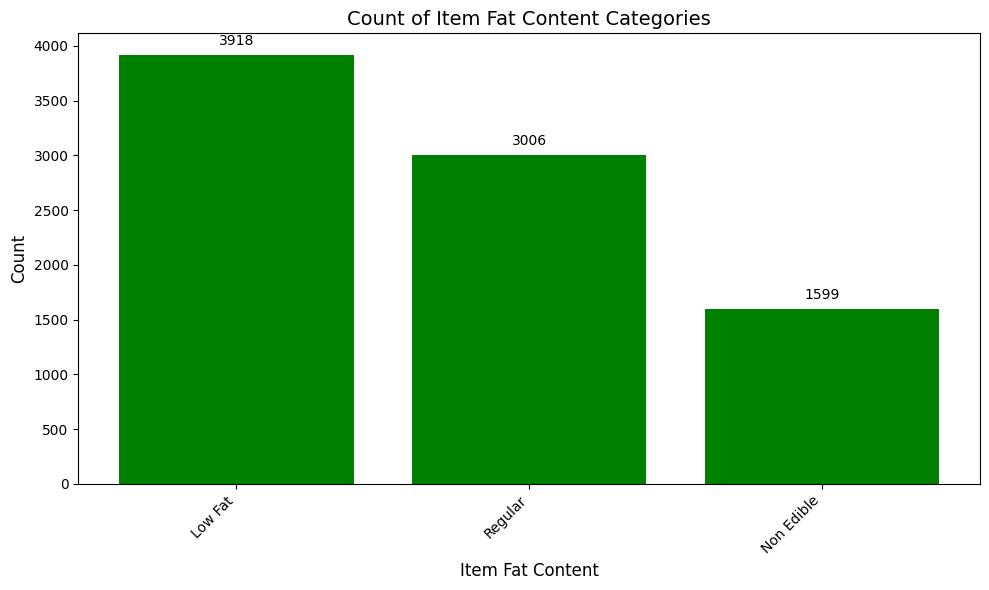

In [40]:
fat_content_counts = sales_data['Item_Fat_Content'].value_counts()

plt.figure(figsize=(10, 6))


bars = plt.bar(fat_content_counts.index, fat_content_counts.values, color='green')

# Add annotations on top of each bar
for bar in bars:
    plt.annotate(
        str(bar.get_height()),  
        xy=(bar.get_x() + bar.get_width() / 2.0, bar.get_height()),  
        ha='center',  
        va='bottom',  
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title('Count of Item Fat Content Categories', fontsize=14)
plt.xlabel('Item Fat Content', fontsize=12)
plt.ylabel('Count', fontsize=12)


plt.xticks(rotation=45, ha='right')
#plt.savefig('item_fat_content_count.png')
plt.tight_layout() 
plt.show()


### Distribution of item types

##### Creating a bar graph to display the count of each category in Item_Type, ensure there are no null values, identify all unique values in Item_Type, and save the plot as a PNG file.

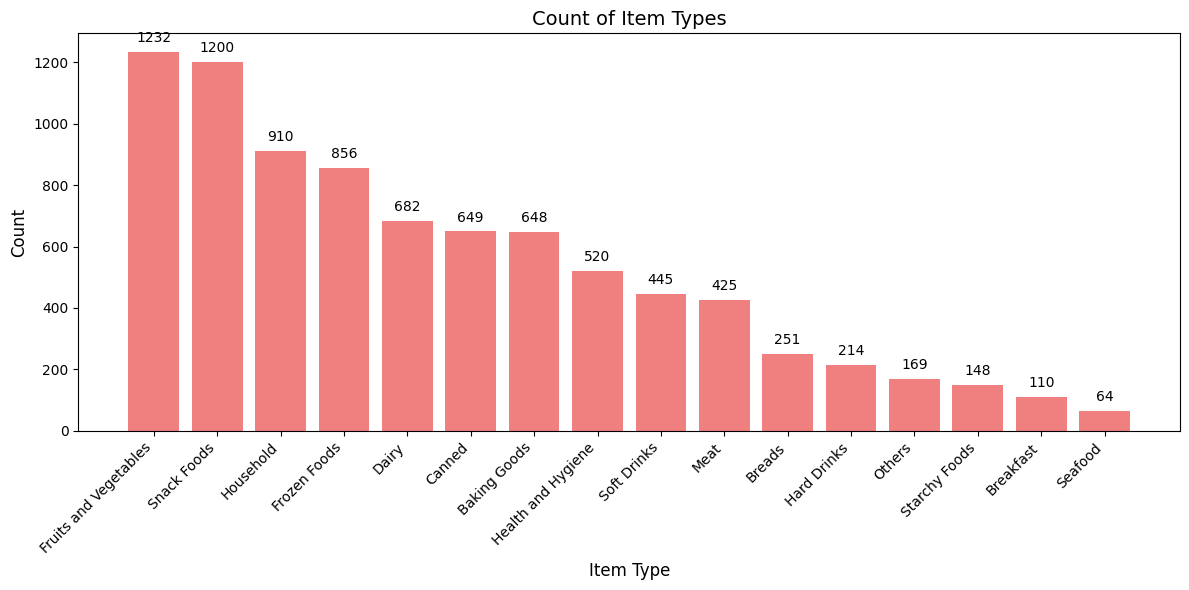

In [41]:
item_type_counts = sales_data['Item_Type'].value_counts()

plt.figure(figsize=(12, 6))

bars = plt.bar(item_type_counts.index, item_type_counts.values, color='lightcoral')

for bar in bars:
    plt.annotate(
        str(bar.get_height()),
        xy=(bar.get_x() + bar.get_width() / 2.0, bar.get_height()),
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('Count of Item Types', fontsize=14)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('item_type_count.png')
plt.show()

### Distribution of outlet establishment years

##### Create a bar graph to display the count of each category in Outlet_Establishment_Year, ensure there are no null values, identify all unique values in Outlet_Establishment_Year, and save the plot as a PNG file.

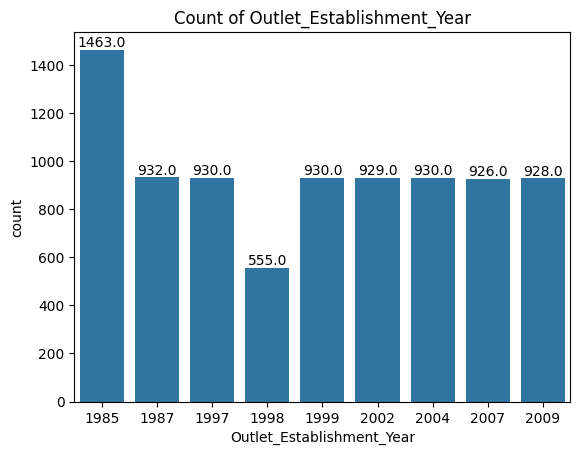

In [42]:
plot = sns.countplot(x = sales_data['Outlet_Establishment_Year'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Establishment_Year')
#plt.savefig('outlet_establishment_year_count.png')
plt.show()

### Distribution of outlet location type

##### Create a bar graph to display the count of each category in Outlet_Location_Type, ensure there are no null values, identify all unique values in Outlet_Location_Type, and save the plot as a PNG file.

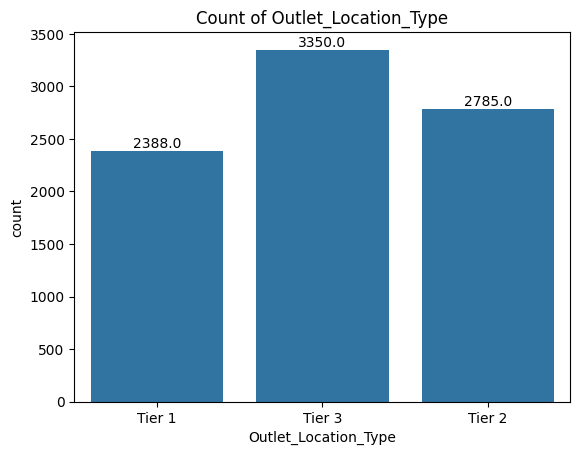

In [43]:
plot = sns.countplot(x = sales_data['Outlet_Location_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Location_Type')
#plt.savefig('outlet_location_type_count.png')
plt.show()

### Distribution of outlet size

##### Create a bar graph to display the count of each category in Outlet_Size, ensure there are no null values, identify all unique values in Outlet_Size, and save the plot as a PNG file.

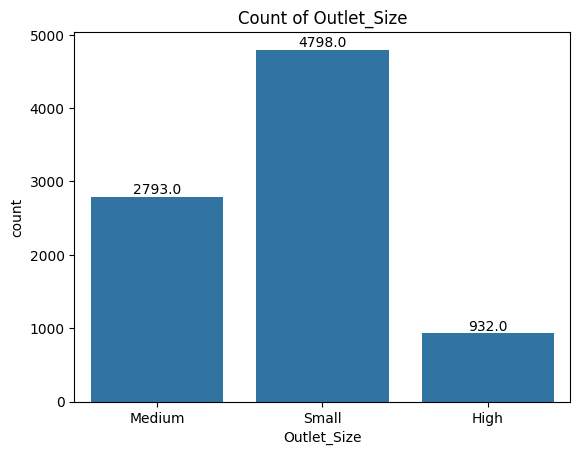

In [44]:
plot = sns.countplot(x = sales_data['Outlet_Size'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Size')
#plt.savefig('outlet_size_count.png')
plt.show()

### Distribution of outlet type

##### Create a bar graph to display the count of each category in Outlet_Type, ensure there are no null values, identify all unique values in Outlet_Type, and save the plot as a PNG file.

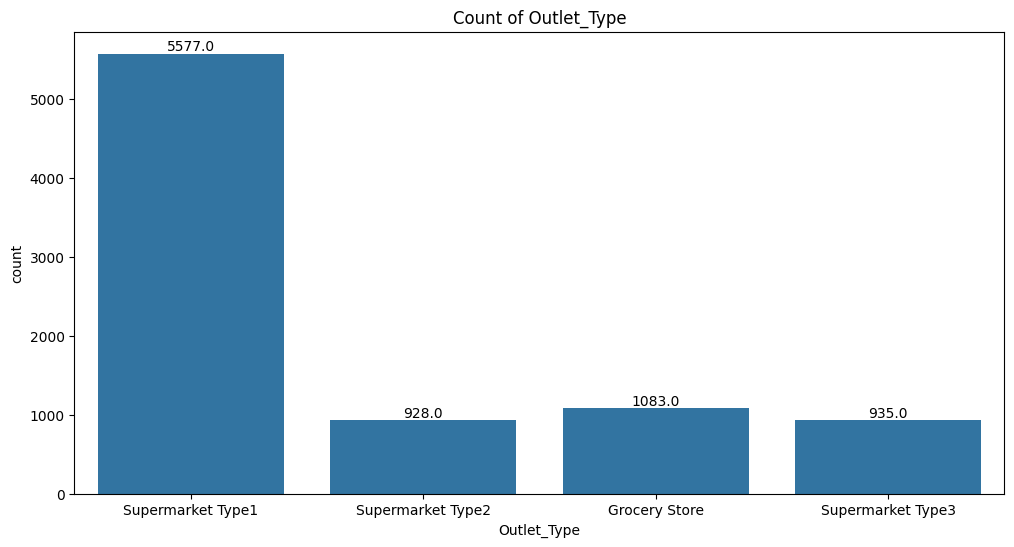

In [45]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(x =sales_data['Outlet_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Type')
#plt.savefig('outlet_type_count.png')
plt.show()

### Distribution of item weight

##### Visualizing the data distribution of the Item_weight column against the density distribution using Seaborn Distplot and saving the PNG file

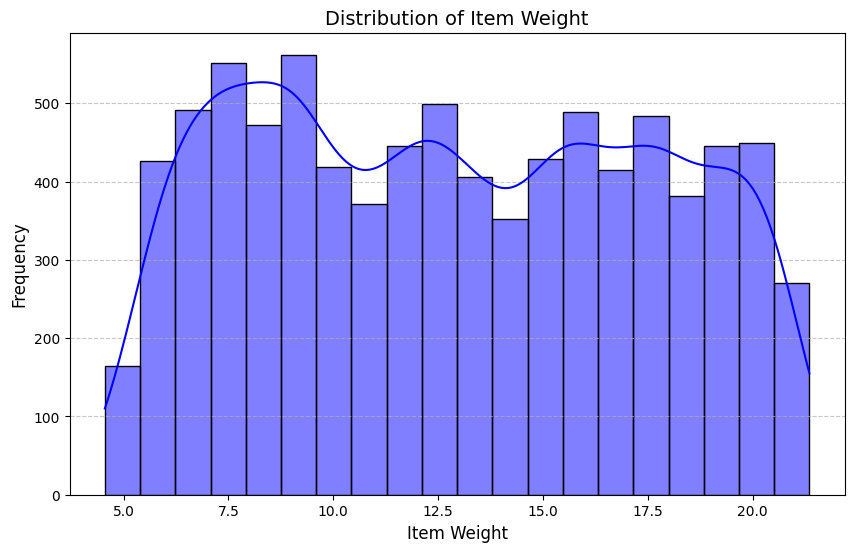

In [46]:
plt.figure(figsize=(10, 6))  
sns.histplot(sales_data['Item_Weight'], bins=20, kde=True, color='blue')  
plt.title('Distribution of Item Weight', fontsize=14)  
plt.xlabel('Item Weight', fontsize=12) 
plt.ylabel('Frequency', fontsize=12)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  


#plt.savefig('Distribution_of_Item_Weight.png')
plt.show()

### Generating a Correlation Heatmap for numeric columns in the dataset

##### Getting the Correlation Values from all the numeric columns from the dataset using Seaborn Heatmap & saving the PNG File

In [47]:
# First, we get all the numerical columns in a list
numerical_columns_list = []

# iterating over the columns in the df
for feature in sales_data.columns:
    if sales_data[feature].dtype == "float64" or sales_data[feature].dtype == "int64":
        numerical_columns_list.append(feature)


In [48]:
# Now we get the data of all the numerical columns from the sales_data dataset

numerical_columns_data = sales_data[numerical_columns_list]

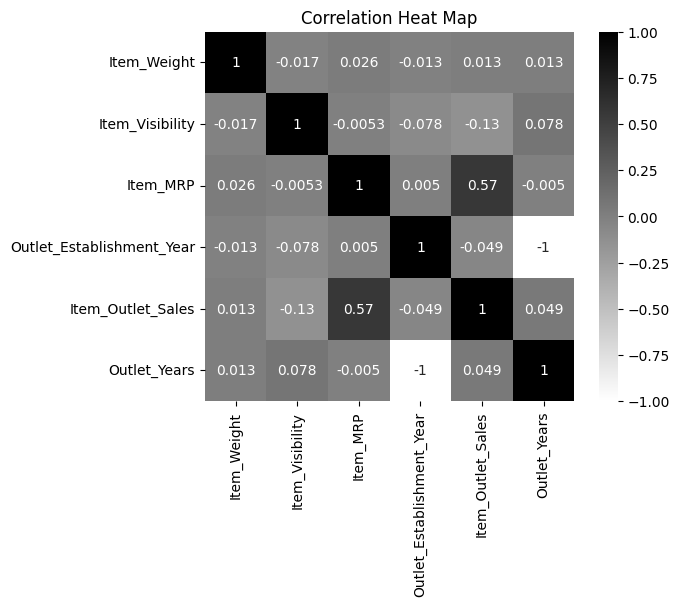

In [49]:
# Creating a correlation heatmap

sns.heatmap(numerical_columns_data.corr(),cmap = 'binary', cbar = True, annot = True, square = True)
plt.title('Correlation Heat Map')
#plt.savefig('correlation_heat_map.png')
plt.show()

## Data Preprocessing